c:\Users\rabiy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e+06, tolerance: 8.662e+02
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\rabiy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.445e+06, tolerance: 8.662e+02
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of th

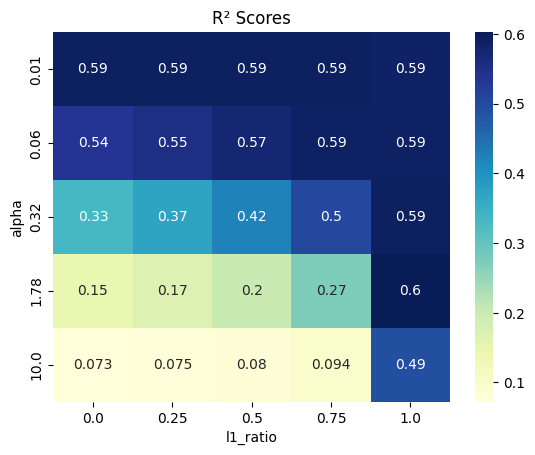

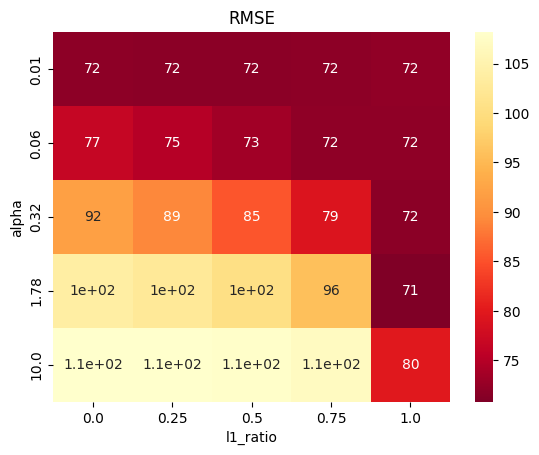

c:\Users\rabiy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LogReg] Penalty=l2, Solver=lbfgs | F1=0.84, AUROC=0.88, AUPRC=0.89
[LogReg] Penalty=l2, Solver=saga | F1=0.80, AUROC=0.83, AUPRC=0.83
Skipped config: penalty=none, solver=lbfgs due to The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.
Skipped config: penalty=none, solver=saga due to The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.


c:\Users\rabiy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[kNN] k=1 | F1=0.71, AUROC=0.65, AUPRC=0.67
[kNN] k=5 | F1=0.73, AUROC=0.75, AUPRC=0.77
[kNN] k=10 | F1=0.73, AUROC=0.75, AUPRC=0.76


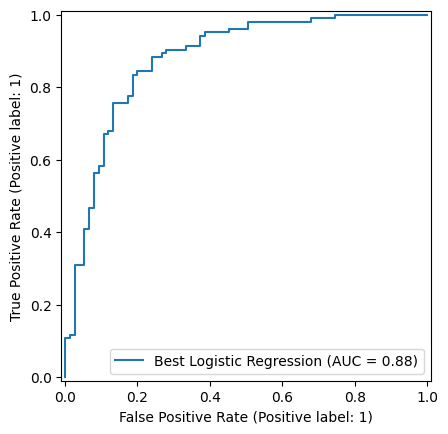

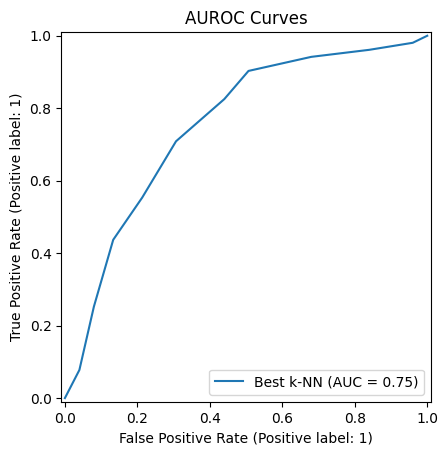

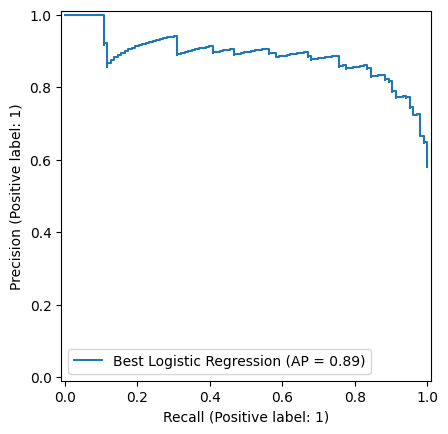

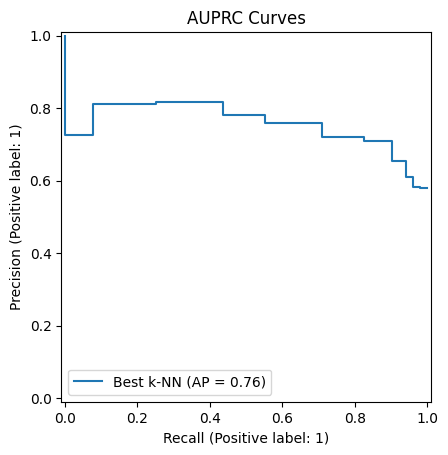

In [ ]:
#Part 3. Build and evaluate models
#1.Regression Models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

# Load dataset
df = pd.read_csv("C:/Users/rabiy/Desktop/BINF 5507 - Machine Learning & AI/Assignment-2/heart_disease_uci(1).csv")

# Drop rows with missing target
df = df.dropna(subset=["chol"])

# Define features and target
X = df.drop(columns=["chol"])
y = df["chol"]

# Infer column types after target removed
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessor that handles both numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="mean"), numeric_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(drop="first"))
        ]), categorical_cols)
    ]
)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run ElasticNet across grid of alpha and l1_ratio
alphas = np.logspace(-2, 1, 5)
l1_ratios = np.linspace(0, 1, 5)
results_r2 = np.zeros((len(alphas), len(l1_ratios)))
results_rmse = np.zeros((len(alphas), len(l1_ratios)))

for i, alpha in enumerate(alphas):
    for j, l1 in enumerate(l1_ratios):
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42))
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        results_r2[i, j] = r2_score(y_test, y_pred)
        results_rmse[i, j] = np.sqrt(mean_squared_error(y_test, y_pred))

# Plot R2 heatmap
sns.heatmap(results_r2, xticklabels=np.round(l1_ratios, 2), yticklabels=np.round(alphas, 2), annot=True, cmap="YlGnBu")
plt.title("R² Scores")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")
plt.show()

# Plot RMSE heatmap
sns.heatmap(results_rmse, xticklabels=np.round(l1_ratios, 2), yticklabels=np.round(alphas, 2), annot=True, cmap="YlOrRd_r")
plt.title("RMSE")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")
plt.show()

#2.Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Binary target
df["num"] = df["num"].apply(lambda x: 1 if x > 0 else 0)

# Define X and y
X = df.drop(columns=["num"])
y = df["num"]

# Re-identify columns after removing target
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="mean"), numeric_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OneHotEncoder(drop="first"))
    ]), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
penalties = ["l2", "none"]
solvers = ["lbfgs", "saga"]
best_lr_model = None
best_lr_score = 0

for penalty in penalties:
    for solver in solvers:
        try:
            model = Pipeline([
                ("prep", preprocessor),
                ("clf", LogisticRegression(penalty=penalty, solver=solver, max_iter=1000))
            ])
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

            f1 = f1_score(y_test, y_pred)
            auroc = roc_auc_score(y_test, y_proba)
            auprc = average_precision_score(y_test, y_proba)

            if auroc > best_lr_score:
                best_lr_score = auroc
                best_lr_model = model
                best_lr_proba = y_proba

            print(f"[LogReg] Penalty={penalty}, Solver={solver} | F1={f1:.2f}, AUROC={auroc:.2f}, AUPRC={auprc:.2f}")
        except Exception as e:
            print(f"Skipped config: penalty={penalty}, solver={solver} due to {e}")

# k-NN
neighbors = [1, 5, 10]
best_knn_model = None
best_knn_score = 0

for k in neighbors:
    model = Pipeline([
        ("prep", preprocessor),
        ("clf", KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_proba)
    auprc = average_precision_score(y_test, y_proba)

    if auroc > best_knn_score:
        best_knn_score = auroc
        best_knn_model = model
        best_knn_proba = y_proba

    print(f"[kNN] k={k} | F1={f1:.2f}, AUROC={auroc:.2f}, AUPRC={auprc:.2f}")

# Plot AUROC + AUPRC curves for best models
RocCurveDisplay.from_predictions(y_test, best_lr_proba, name="Best Logistic Regression")
RocCurveDisplay.from_predictions(y_test, best_knn_proba, name="Best k-NN")
plt.title("AUROC Curves")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, best_lr_proba, name="Best Logistic Regression")
PrecisionRecallDisplay.from_predictions(y_test, best_knn_proba, name="Best k-NN")
plt.title("AUPRC Curves")
plt.show()